# Compare to Single Velocity Model
Assess how well our model trained on separate velocities compares to our previous models trained on only a single velocity

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os

Using TensorFlow backend.


## Load in the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [2]:
model = keras.models.load_model('model.h5')

In [3]:
with open('featurizer.pkl', 'rb') as fp:
    featurizers = pkl.load(fp)

In [4]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [5]:
train_data = pd.concat([
    pd.read_pickle(os.path.join('data', 'random_traj.pkl')),
    pd.read_pickle(os.path.join('data', 'channel_traj.pkl'))
], sort=False)

In [6]:
with open(os.path.join('..', 'single-velocity', 'traj_computer.pkl'), 'rb') as fp:
    traj_int_single = pkl.load(fp)

In [7]:
data = pd.read_pickle(os.path.join('..', 'training_data.pkl.gz'))

## Retrain on Both Channel and Random
This will give us a direct comparison to the single velocity model. The weights will start from the weights learned from the random trajectory.

In [8]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [9]:
callbacks = [keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto'),
             keras.callbacks.ReduceLROnPlateau('mean_absolute_error', min_delta=1e-6)]

In [10]:
%%time
history = model.fit(train_data[featurizers.feature_labels()], train_data['force'], callbacks=callbacks, verbose=0, epochs=1000)

CPU times: user 17min 10s, sys: 2min 24s, total: 19min 34s
Wall time: 18min 12s


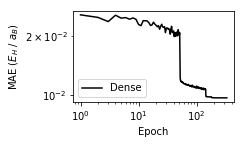

In [11]:
fig, ax = plt.subplots()

ax.loglog(history.epoch, history.history['mean_absolute_error'], 'k', label='Dense')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.legend()

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()

*Finding*: It does converge in a few hundred epochs

## Get Trajectory Integration Tools
These black box the annoying parts of making the trajectories. We'll re-use the one for single velocities (imported earlier)

In [12]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

## Plot the Performance on $v=1.0$ Trajectories
This is the trajectories for which we have the most data

In [13]:
v1_data = data[np.isclose(data['velocity_mag'], 1.0, atol=1e-3)]

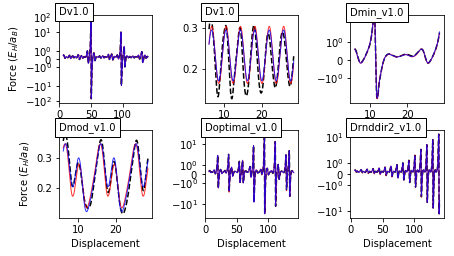

In [14]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

acc_scores = []

for i, (ax, (d, subset)) in enumerate(zip(axs, v1_data.groupby('directory'))):
    subset = subset.query('displacement > 6')
    
    # Get the values
    single_pred = traj_int_single.model.predict(subset[traj_int_single.featurizers.feature_labels()])
    multi_pred = traj_int.model.predict(subset[traj_int.featurizers.feature_labels()])
    
    # Plot them
    ax.plot(subset['displacement'], subset['force'], 'k--')
    ax.plot(subset['displacement'], single_pred, 'r', lw=1, alpha=0.8)
    ax.plot(subset['displacement'], multi_pred, 'b', lw=1, alpha=0.8)
    
    if subset['force'].max() > 1:
        ax.set_yscale('symlog')
    
    # Make a label for the figure
    ax.text(0, 1, os.path.basename(d), bbox={'facecolor': 'w', 'edgecolor': 'k'},
           transform=ax.transAxes)
    
    # Make axes labels
    if i >= 3:
        ax.set_xlabel('Displacement')
    if i % 3 == 0:
        ax.set_ylabel('Force ($E_H / a_B$)')
        
    # Measure the accuracy
    acc_scores.append({
        'subset': d,
        'mae_single': mean_absolute_error(subset['force'], single_pred),
        'mae_multi': mean_absolute_error(subset['force'], multi_pred),
        'spearman_single': spearmanr(subset['force'], single_pred)[0],
        'spearman_multi': spearmanr(subset['force'], multi_pred)[0],
        'stopping': subset['force'].mean(),
        'stopping_single': single_pred.mean(),
        'stopping_multi': multi_pred.mean(),
    })
        
            
fig.tight_layout()
fig.set_size_inches(6.5, 3.5)
fig.savefig(os.path.join('figures', 'validation-set.png'), dpi=320)

*Finding*: They look pretty similar

### Compare the Scores Quantitatively
See if the models just "appear better"

In [15]:
acc_scores = pd.DataFrame(acc_scores)

In [16]:
acc_scores

,mae_multi,mae_single,spearman_multi,spearman_single,stopping,stopping_multi,stopping_single,subset
0,0.011162,0.017575,0.994779,0.992617,0.240193,0.238402,0.238360,datasets/256_Al/Dv1.0
1,0.022499,0.022613,0.901681,0.889739,0.221916,0.234343,0.234292,datasets/Al_256_channel/Dv1.0
2,0.019232,0.021426,0.997005,0.995640,0.270083,0.269725,0.260794,datasets/Al_256_new/Dmin_v1.0
3,0.012049,0.020603,0.987373,0.947753,0.241831,0.244556,0.237271,datasets/Al_256_new/Dmod_v1.0
4,0.021703,0.024529,0.995771,0.994819,0.240920,0.239341,0.242884,datasets/Al_256_new/Doptimal_v1.0
5,0.017369,0.018639,0.992801,0.989084,0.248845,0.251400,0.249989,datasets/Al_256_new/Drnddir2_v1.0


#### Compare Fitness to Forces
This is one metric of success

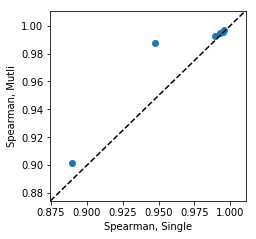

In [17]:
fig, ax = plt.subplots()

ax.scatter(acc_scores['spearman_single'], acc_scores['spearman_multi'])

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('Spearman, Single')
ax.set_ylabel('Spearman, Mutli')

fig.set_size_inches(3.5, 3.5)

*Finding*: The Spearman correlation coefficient for the multi-velocity model is generally better.

### Compare Stopping Powers
Which gives a better stopping power prediction

In [18]:
print('Multi-Velocity MAE: {:.3e} E_H/a_B'.format(mean_absolute_error(acc_scores['stopping'], acc_scores['stopping_multi'])))

Multi-Velocity MAE: 3.572e-03 E_H/a_B


In [19]:
print('Single-Velocity MAE: {:.3e} E_H/a_B'.format(mean_absolute_error(acc_scores['stopping'], acc_scores['stopping_single'])))

Single-Velocity MAE: 5.194e-03 E_H/a_B


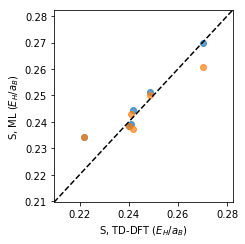

In [22]:
fig, ax = plt.subplots()

ax.scatter(acc_scores['stopping'], acc_scores['stopping_multi'], label='Multi', alpha=0.7)
ax.scatter(acc_scores['stopping'], acc_scores['stopping_single'], label='Single', alpha=0.7)

ax.set_ylim(ax.get_xlim())
ax.set_xlim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('S, TD-DFT ($E_H/a_B$)')
ax.set_ylabel('S, ML ($E_H/a_B$)')

fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

*Finding*: The multi-velocity model has *slightly* better stopping power predictions.